In [1]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

In [122]:
def gen_var(W, T):
    p = np.shape(W)[0]
    noises = np.zeros((2 * T, p))
    
    X = np.zeros((2 * T, p))
    X[0] = np.random.multivariate_normal(np.zeros(p), np.identity(p))
    
    noises[1:] = np.random.multivariate_normal(np.zeros(p), np.identity(p), 2 * T - 1)
    
    noises *= np.expand_dims(np.linspace(1, 50, 2 * T), axis = -1)
    
    for t in range(1, 2 * T):
        X[t] = X[t - 1] @ W + noises[t]
        
    return X[T:]

def gen_var_noises(W, T, noises):
    p = np.shape(W)[0]
    
    X = np.zeros((T, p))
    X[0] = noises[0]
    
    for t in range(1, T):
        X[t] = X[t - 1] @ W + noises[t]

    return X

def gen_var_noises_stat(W, T, noises):
    p = np.shape(W)[0]
    
    X = np.zeros((T, p))
    X[0] = noises[0]
    
    for t in range(1, T):
        X[t] = X[t - 1] @ W + noises[t]

    return X[T // 2:]

In [109]:
## First approach: A is a DAG, no model mismatch
A_2 = h.generate_A(p, 0, tril = True, low = 0.50, high = 0.75)

# set coefficients to be positive (else oscillating which does not make sense)
for i in range(len(A_2)):
    A_2[i][i] = 0.6 # np.abs(A_true[i][i])

True W:
[[ 0.6   0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.6   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.62  0.    0.6   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.73  0.6   0.    0.    0.    0.    0.    0.  ]
 [-0.64  0.57  0.    0.    0.6   0.    0.    0.    0.    0.  ]
 [ 0.   -0.52  0.    0.    0.    0.6   0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.71  0.    0.69  0.6   0.    0.    0.  ]
 [ 0.    0.   -0.66  0.    0.    0.   -0.7   0.6   0.    0.  ]
 [ 0.    0.    0.    0.    0.65  0.    0.    0.    0.6   0.  ]
 [ 0.    0.   -0.53 -0.71  0.    0.    0.63  0.68 -0.59  0.6 ]].



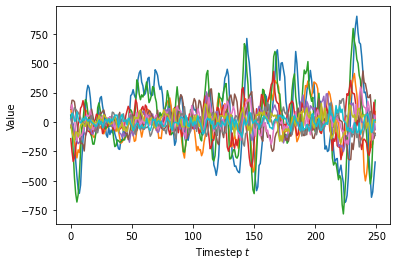

In [124]:
# np.random.seed(seed = 12345)

# Number of dimensions, number of edges, number of samples
T, p, s = 250, 10, 15

N = int(p * (p + 1) / 2)

### Coefficient matrix
## First approach: A is a DAG, no model mismatch
A_true = h.generate_A(p, s, tril = True, low = 0.50, high = 0.75)

# set coefficients to be positive (else oscillating which does not make sense)
for i in range(len(A_true)):
    A_true[i][i] = 0.6 # np.abs(A_true[i][i])

s = len(A_true.flatten().nonzero()[0])

## True permutation
P_true = np.identity(p) # np.random.permutation(np.identity(n))

## Datagenerating W
W_true = P_true.T @ A_true @ P_true
print(f"True W:\n{np.round(W_true, 2)}.\n")

## Generate series
# noises = gen_var(A_2, 2 * T)
# X = gen_var_noises_stat(W_true, 2 * T, noises)
X = gen_var(A_true, T)

## Plot series
plt.xlabel(r"Timestep $t$")
plt.ylabel(r"Value")
plt.plot(X); 

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	161	162	163	164	165	166	167	168	169	170	171	172	173	174	175	176	177	178	179	180	181	182	183	184	185	186	187	188	189	190	191	192	193	194	195	196	197	198	199	200	201	202	203	204	205	206	207	208	209	210	211	212	213	214	215	216	217	218	219	220	221	222	223	224	225	226	227	228	229	230	231	232	233	234	235	236	237	238	239	240	241	242	243	244	245	246	247	248	True Positive Rate: 1.0.
True Negative Rate: 0.933.
False Prediction Rate: 0.167
Accuracy: 0.95.
R-Squared: 0.947


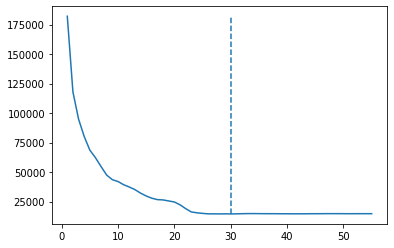

In [125]:
W, Ws, mses, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

x = X[:-1]
y = X[1:]
mses = [[] for i in range(len(Ws))]

for t in range(T - 1):
    print(t, end = "\t")
    x_train = np.delete(x, t, axis = 0)
    y_train = np.delete(y, t, axis = 0)
    
    W, Ws, _ = m._K_OMP_output(x_train, y_train, F = [], normalize = True)
    for j, W in enumerate(Ws):
        mses[j].append(np.linalg.norm(y[t] - x[t] @ W, 2) ** 2)
    

mses_avg = [sum(mse) / len(mse) for mse in mses]
# plt.plot(X)
# plt.show()
plt.vlines(np.argmin(mses_avg) + 1, min(mses_avg), max(mses_avg), linestyle = '--')
plt.plot(range(1, len(mses_avg) + 1), mses_avg)
h.score(X, m._constrained_OLS(X, Ws[np.argmin(mses_avg)] != 0), W_true);
h.score(X, m._constrained_OLS(X, Ws[s] != 0), W_true);

In [118]:
h.score(X, m._constrained_OLS(X, Ws[30] != 0), W_true);

True Positive Rate: 0.92.
True Negative Rate: 0.893.
False Prediction Rate: 0.258
Accuracy: 0.9.
R-Squared: 0.985
Mean Squared Error: 14.766


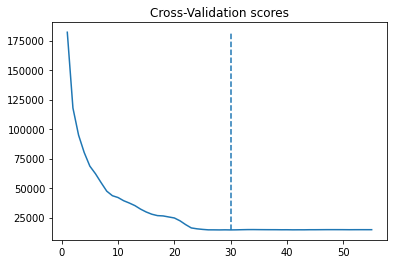

In [126]:
plt.title("Cross-Validation scores")
plt.vlines(np.argmin(mses_avg) + 1, min(mses_avg), max(mses_avg), linestyle = '--')
plt.plot(range(1, len(mses_avg) + 1), mses_avg)

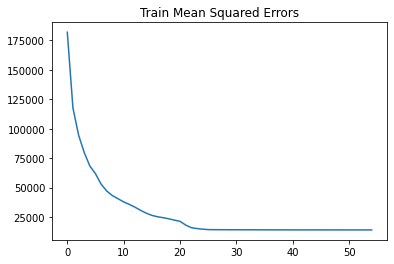

In [127]:
plt.title("Train Mean Squared Errors")
plt.plot([h.MSE(W, X) for W in Ws])

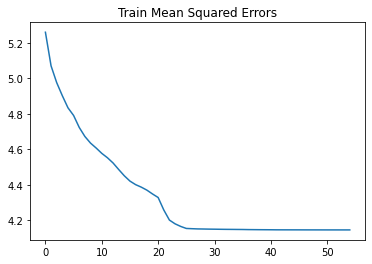

In [128]:
plt.title("Train Mean Squared Errors")
plt.plot([np.log10(h.MSE(W, X)) for W in Ws])